In [ ]:
# ====================================
# STEP 1: INSTALL REQUIRED LIBRARIES
# ====================================
!pip install sdv pandas numpy scikit-learn matplotlib seaborn xgboost


In [ ]:
!unzip /content/creditcard.csv(1).zip -d /content/unzipped_folder


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `unzip /content/creditcard.csv(1).zip -d /content/unzipped_folder'


In [ ]:
# ====================================
# STEP 2: LOAD CREDITCARD.CSV
# ====================================
import pandas as pd

# Assuming the file is already unzipped in the specified folder
file_path = '/content/creditcard.csv (1).zip'

try:
    df = pd.read_csv(file_path)
    print("Dataset Shape:", df.shape)
    display(df.head())

    # NOTE: You can type your own notes below in Colab:
    # Observations:
    # 1. ____________________________________
    # 2. ____________________________________

except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}. Please ensure it is unzipped in the correct location.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

Dataset Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# ====================================
# STEP 4: ISOLATE FRAUD CASES FOR SYNTHETIC GENERATION
# ====================================

fraud_data = df[df['Class'] == 1].reset_index(drop=True)
print("Fraud Samples Shape:", fraud_data.shape)

# Drop Time column (not necessary for modeling)
fraud_data = fraud_data.drop(columns=['Time'])

# NOTE: This will help CTGAN learn the minority class pattern better.


Fraud Samples Shape: (492, 31)


In [ ]:
 # ====== Cell 5: Train CTGAN (new SDV API) ======
# This cell uses SingleTableMetadata + CTGANSynthesizer (compatible with sdv >= 1.x)

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# 1) Create metadata and detect fields from the dataframe
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=fraud_data)  # infers field types

# Optional: inspect metadata (uncomment to see)
# print(metadata.to_dict())

# Training settings
EPOCHS = 100  # increase for better quality; may take longer
# 2) Initialize CTGAN synthesizer with metadata and epochs
ctgan = CTGANSynthesizer(metadata=metadata, epochs=EPOCHS)

# Fit the synthesizer
ctgan.fit(fraud_data)

# 3) Generate synthetic fraud samples
SYNTHETIC_ROWS = 5000  # change if you want fewer/more
synthetic_fraud = ctgan.sample(num_rows=SYNTHETIC_ROWS)

# Ensure Class column present and equals 1
synthetic_fraud['Class'] = 1
print("Synthetic fraud generated:", synthetic_fraud.shape)
synthetic_fraud.head()

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:167: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:133: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Synthetic fraud generated: (5000, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-3.254875,0.139852,1.368736,2.046346,-2.558310,0.479572,-22.401389,9.595301,-7.573316,-2.139647,...,0.218605,1.317409,0.729396,-0.516861,-0.195971,0.029627,0.571658,-0.290644,0.00,1
1,-2.306892,12.423880,-17.811733,12.114672,-6.843683,-5.828681,-6.599587,20.007208,-3.561468,-0.637152,...,2.053363,-0.471141,-2.467109,-1.177167,-0.464314,0.362718,-0.253184,-0.096151,176.14,1
2,-4.435128,1.354755,-8.533554,6.798714,-4.316568,-3.094682,-14.839222,10.524489,-4.352868,1.450705,...,5.196029,0.419505,0.331490,-1.093719,0.601899,-0.211284,0.821248,0.172371,0.00,1
3,-27.123921,-0.272994,-3.226741,5.921985,-16.704233,-2.925052,-8.055539,4.436391,-4.873926,0.911661,...,-1.797016,-0.144862,-0.344627,0.113390,0.571110,-0.186448,1.003643,0.131257,0.00,1
4,-4.988536,5.516838,-1.033312,12.114672,-1.506027,0.031151,-14.189941,0.127126,-6.363514,0.464953,...,2.059208,-2.539120,-0.431035,-1.709888,0.404354,0.427574,-0.167033,0.404414,5.34,1


In [ ]:
# ====== Cell 6: Augment dataset (real + synthetic) ======
# Drop Time from original for consistency
original = df.copy()
if 'Time' in original.columns:
    original = original.drop(columns=['Time'])

augmented = pd.concat([original, synthetic_fraud], ignore_index=True)
augmented = augmented.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

print("Original shape:", original.shape)
print("Augmented shape:", augmented.shape)
augmented.head()


Original shape: (284807, 30)
Augmented shape: (289807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.214111,0.573411,2.907422,1.355873,-1.174616,1.573442,0.830477,-0.344487,1.003815,0.268264,...,-0.062443,0.708791,-0.280562,0.145173,0.135885,-0.162246,-0.634738,-0.438097,173.44,0
1,-4.374494,1.720756,-0.283283,-1.419023,-0.540330,-0.235455,0.141986,-0.178588,2.659507,2.821716,...,-0.446591,-0.419491,0.391924,-0.456796,0.034762,-0.455549,-1.786650,-0.330895,13.87,0
2,1.097677,-0.164882,0.176646,0.734756,0.025320,0.673811,-0.336997,0.344617,0.283078,0.118485,...,-0.176758,-0.728021,-0.041762,-1.246892,0.267670,-0.537954,0.025471,0.014927,61.00,0
3,2.160707,0.011426,-2.483200,-0.280012,0.914775,-0.945271,0.646703,-0.372235,0.119328,0.212958,...,0.124816,0.446405,-0.171981,-0.996681,0.521044,0.286452,-0.095692,-0.100791,3.70,0
4,1.272196,0.472315,-1.107531,0.793957,1.039064,0.504867,-0.006639,0.235595,-0.010333,-0.510556,...,-0.119193,-0.335503,-0.302328,-1.884768,0.768501,-0.202959,0.035910,0.023181,1.00,0


In [ ]:
# ====== Cell 7: Train/test split ======
from sklearn.model_selection import train_test_split

X = augmented.drop(columns=['Class'])
y = augmented['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (202864, 29) Test: (86943, 29)


In [ ]:
# ====== Cell 8: Train classifier ======
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Choose model: RandomForest (fast) or XGBoost (often better)
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Model trained.")


Model trained.


Classification Report:

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     85295
           1     0.9945    0.9806    0.9875      1648

    accuracy                         0.9995     86943
   macro avg     0.9970    0.9902    0.9936     86943
weighted avg     0.9995    0.9995    0.9995     86943

ROC AUC: 0.993973969268279


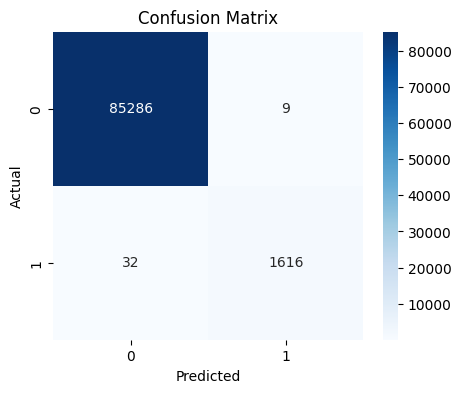

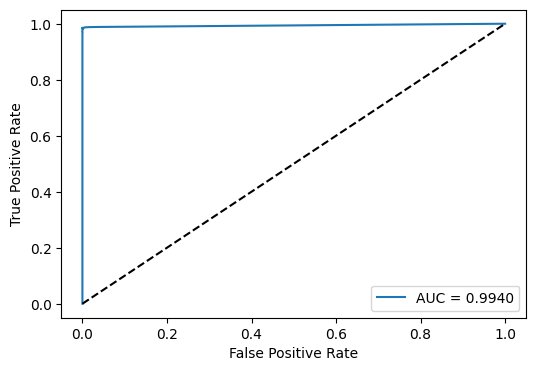

In [ ]:
# ====== Cell 9: Evaluation ======
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", auc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
# ====== Cell 10: Save augmented dataset & model (optional) ======
# Save augmented dataset and synthetic sample CSVs to disk in Colab
augmented.to_csv("augmented_dataset.csv", index=False)
synthetic_fraud.to_csv("synthetic_fraud.csv", index=False)

# Save model with joblib
import joblib
joblib.dump(model, "fraud_model_rf.joblib")

print("Files saved: augmented_dataset.csv, synthetic_fraud.csv, fraud_model_rf.joblib")


Files saved: augmented_dataset.csv, synthetic_fraud.csv, fraud_model_rf.joblib
